In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# %pip install --upgrade tensorflow
# %pip install keras==2.12.0
# %pip install --upgrade joblib
# %pip install scikeras

In [2]:
import h5py
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import gc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation
from sklearn.model_selection import GridSearchCV
from keras.utils import to_categorical
from tensorflow import keras
import pywt

from tensorflow.keras.layers import Conv1D,BatchNormalization,LeakyReLU,MaxPool1D,\
GlobalAveragePooling1D,Dense,Dropout,AveragePooling1D
from tensorflow.keras.backend import clear_session


In [ ]:
# ------------------------------ Train Data ------------------------------ #

In [3]:

def load_data(file_path):
    with h5py.File(file_path, 'r') as f:
        dataset_name = get_dataset_name(file_path)
        matrix = f.get(dataset_name)[:]
        return matrix

def get_dataset_name(file_name_with_dir):
    filename_without_dir = file_name_with_dir.split('/')[-1]
    temp = filename_without_dir.split('_')[:-1]
    dataset_name = "_".join(temp)
    return dataset_name

def load_data_by_task(data_folder, task_number):
    meg_data_list = []
    labels = []

    for file in os.listdir(data_folder):
        if task_number in file and file.endswith('.h5'):
            file_path = os.path.join(data_folder, file)
            data = load_data(file_path)
            if data is not None:
                meg_data_list.append(data)
                label = assign_label(file)
                labels.append(label)

    if meg_data_list:
        meg_data_array = np.stack(meg_data_list, axis=0)
        labels_array = np.array(labels)
        return meg_data_array, labels_array
    else:
        return None, None

def assign_label(file_name):
    if file_name.startswith("rest"):
        return 0
    elif file_name.startswith("task_motor"):
        return 1
    elif file_name.startswith("task_story"):
        return 2
    elif file_name.startswith("task_working"):
        return 3
    else:
        return None

def find_fmri_data_folder(start_path):
    for root, dirs, files in os.walk(start_path):
        if 'meg_data' in dirs:
            return os.path.join(root, 'meg_data/Intra/train')
    raise Exception("meg_data folder not found. Please check the directory structure.")


def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y



def apply_scaling(array):
  array_norm = np.zeros((array.shape[0],array.shape[1],array.shape[2]))
  for i in range(array.shape[0]):
    means = np.mean(array[i], axis=1)  # Calculate mean for each sensor
    stds = np.std(array[i], axis=1)    # Calculate standard deviation for each sensor
    array_norm[i] = (array[i] - means[:, np.newaxis]) / stds[:, np.newaxis]   # Subtrack and divide

  del array, means, stds
  gc.collect()
  return array_norm


def apply_lowpass(array):
  original_sampling_rate = 2034  # Original sampling rate
  downsampling_factor = 16
  new_sampling_rate = original_sampling_rate / downsampling_factor  # New sampling rate after downsampling
  cutoff_frequency = new_sampling_rate / 2  # Nyquist frequency

  array_filtered = np.zeros_like(array)

  for o in range(array.shape[0]):
      for i in range(array.shape[1]):
          array_filtered[o, i, :] = butter_lowpass_filter(array[o, i, :], cutoff_frequency, original_sampling_rate)

  del array
  return array_filtered


  del array
  gc.collect()
  return array_filtered


def apply_downsampling(array):
  n_observations, n_sensors, n_timepoints = array.shape
  new_n_timepoints = n_timepoints // 16
  downsampling_factor = 16
  array_downsamp = np.zeros((n_observations, n_sensors, new_n_timepoints))

  for obs in range(n_observations):
    for sensor in range(n_sensors):
      array_downsamp[obs,sensor,:] = array[obs, sensor, ::downsampling_factor]

  del array, new_n_timepoints, downsampling_factor, n_observations, n_sensors, n_timepoints
  gc.collect()
  return array_downsamp


def create_cnn(neurons=32, optimizer='adam', sensors_train=248, points_train=8906):
    clear_session()
    model=Sequential()
    model.add(Conv1D(filters=neurons,kernel_size=3,strides=1,input_shape=(sensors_train, points_train)))#1
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPool1D(pool_size=2,strides=1))#2
    model.add(Conv1D(filters=5,kernel_size=3,strides=1))#3
    model.add(LeakyReLU())
    model.add(MaxPool1D(pool_size=2,strides=1))#4
    model.add(Dropout(0.5))
    model.add(Conv1D(filters=5,kernel_size=3,strides=1))#5
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2,strides=1))#6
    model.add(Dropout(0.5))
    model.add(Conv1D(filters=5,kernel_size=3,strides=1))#7
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2,strides=1))#8
    model.add(Conv1D(filters=5,kernel_size=3,strides=1))#9
    model.add(LeakyReLU())
    model.add(GlobalAveragePooling1D())#10
    model.add(Dense(4,activation='softmax'))#11

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model



fmri_data_folder = find_fmri_data_folder('/content/drive/My Drive')

tasks = ['rest', 'task_motor', 'task_story', 'task_working']
task_numbers = ['_1.','_2.','_3.','_4.','_5.','_6.','_7.','_8.']
visual_data = []

for task in task_numbers:
    print(f"Processing task: {task}")
    X_task, y_task = load_data_by_task(fmri_data_folder, task)

    X_task = X_task[:, :, :-8]

    if X_task is not None and y_task is not None:
        print("Train shape:", X_task.shape)
        print("Test shape:", y_task.shape)

        ##########
        visual_data.append(X_task[0,0])

        # Scaling
        X_task_norm = apply_scaling(X_task)
        del X_task
        gc.collect()
        ##########
        visual_data.append(X_task_norm[0,0])

        # Lowpass filter
        X_task_filtered = apply_lowpass(X_task_norm)
        del X_task_norm
        gc.collect()
        ##########
        visual_data.append(X_task_filtered[0,0])

        # Downsample
        X_task_downsamp = apply_downsampling(X_task_filtered)
        del X_task_filtered
        gc.collect()
        ##########
        visual_data.append(X_task_downsamp[0,0])

        print("After downsampling:", X_task_downsamp.shape)

        # ----- Train the model on this task's data ----- #
        obs_train, sensors_train, points_train = X_task_downsamp.shape

        X_train = X_task_downsamp.reshape((obs_train,sensors_train,points_train))
        y_train = y_task.reshape(y_task.shape[0],1)
        y_train_encoded = to_categorical(y_train, num_classes=4)

        del X_task_downsamp, y_train, y_task, obs_train
        gc.collect()

        optimizer = 'adam'  # Can be 'SGD', 'RMSprop', 'Adam', etc.
        neurons = 36
        batch_size = 10
        epochs = 6

        print(f"Training model on task: {task}")
        if task == '_1.':
          print("#### Model Created ####")
          model = create_cnn(optimizer=optimizer, neurons=neurons, sensors_train=sensors_train, points_train=points_train)

        print("X_train", X_train.shape)
        model.fit(X_train, y_train_encoded, epochs=epochs, batch_size=batch_size)

        # Clear memory
        del X_train, y_train_encoded,
        gc.collect()
        print("---------------------------------")
    else:
        print(f"No data found for task: {task}")



Processing task: _1.
Train shape: (4, 248, 35616)
Test shape: (4,)
After downsampling: (4, 248, 2226)
Training model on task: _1.
#### Model Created ####
X_train (4, 248, 2226)
Epoch 1/6
1/1 [==============================] - 2s 2s/step - loss: 1.3889 - accuracy: 0.2500
Epoch 2/6
1/1 [==============================] - 0s 65ms/step - loss: 1.1592 - accuracy: 0.2500
Epoch 3/6
1/1 [==============================] - 0s 69ms/step - loss: 1.1042 - accuracy: 0.5000
Epoch 4/6
1/1 [==============================] - 0s 53ms/step - loss: 1.0772 - accuracy: 0.5000
Epoch 5/6
1/1 [==============================] - 0s 51ms/step - loss: 1.0613 - accuracy: 0.5000
Epoch 6/6
1/1 [==============================] - 0s 59ms/step - loss: 1.0406 - accuracy: 0.5000
---------------------------------
Processing task: _2.
Train shape: (4, 248, 35616)
Test shape: (4,)
After downsampling: (4, 248, 2226)
Training model on task: _2.
X_train (4, 248, 2226)
Epoch 1/6
1/1 [==============================] - 0s 74ms/step 

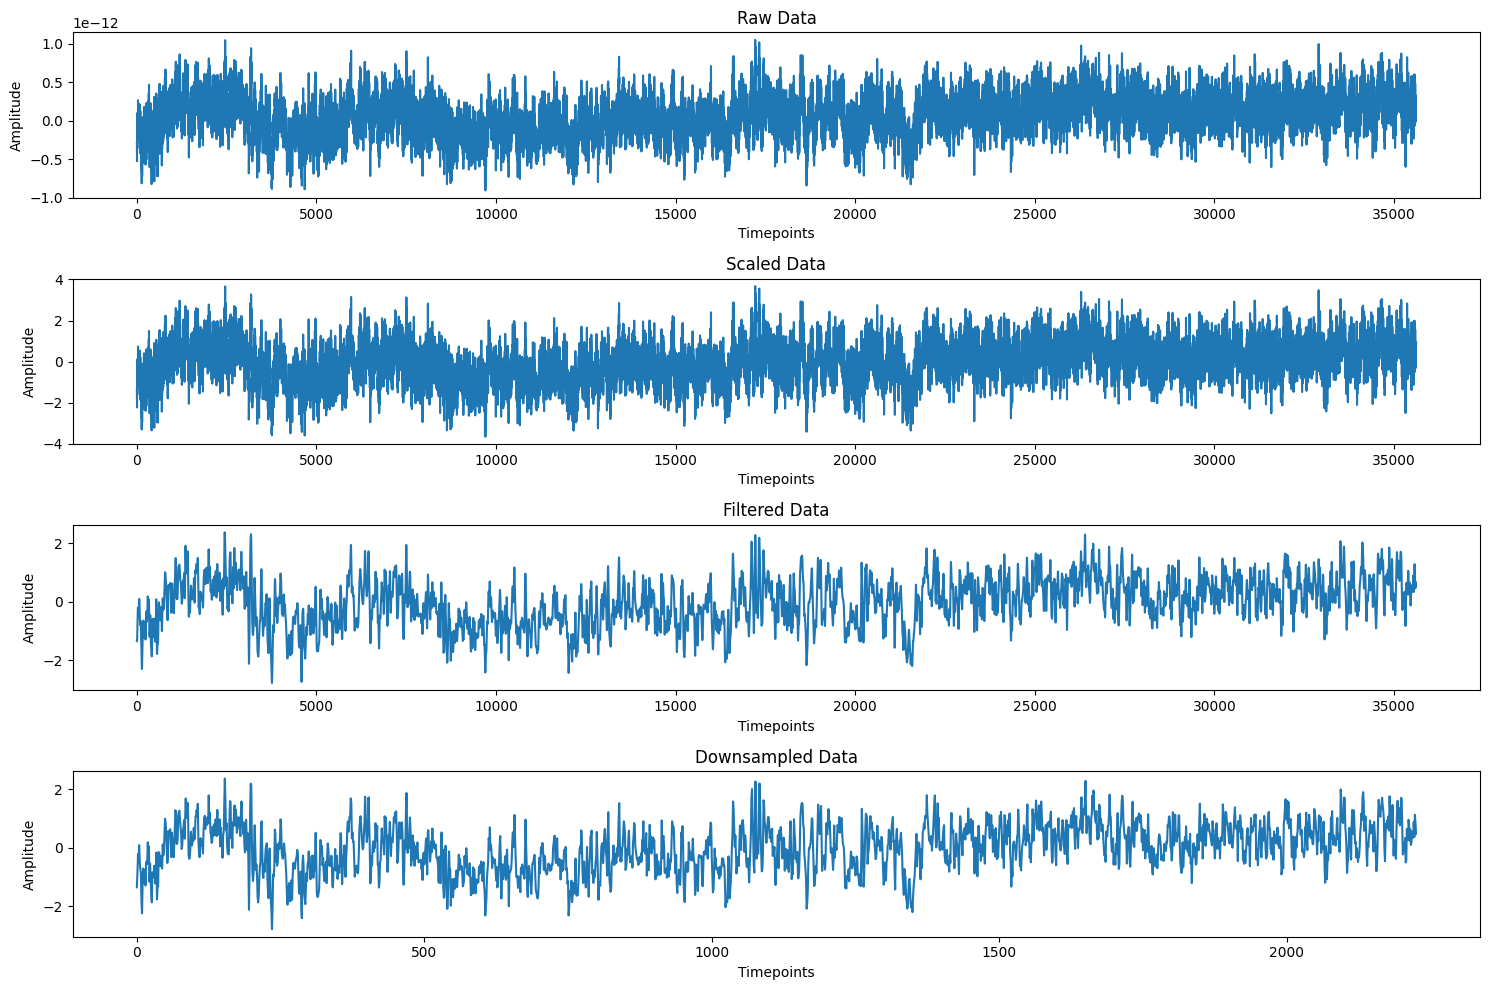

In [ ]:
# Visualize the signal of the first sensor after each step
import matplotlib.pyplot as plt

# Assuming each array is a NumPy array and the first sensor's data is the first row
# Example: raw_data[0, :], scaled_data[0, :], etc.

plt.figure(figsize=(15, 10))

# Plot Raw Data
plt.subplot(4, 1, 1)  # 4 rows, 1 column, 1st subplot
plt.plot(visual_data[0], label='Raw Data')
plt.title('Raw Data')
plt.xlabel('Timepoints')
plt.ylabel('Amplitude')

# Plot Scaled Data
plt.subplot(4, 1, 2)  # 4 rows, 1 column, 2nd subplot
plt.plot(visual_data[1], label='Scaled Data')
plt.title('Scaled Data')
plt.xlabel('Timepoints')
plt.ylabel('Amplitude')

# Plot Filtered Data
plt.subplot(4, 1, 3)  # 4 rows, 1 column, 3rd subplot
plt.plot(visual_data[2], label='Filtered Data')
plt.title('Filtered Data')
plt.xlabel('Timepoints')
plt.ylabel('Amplitude')

# Plot Downsampled Data
plt.subplot(4, 1, 4)  # 4 rows, 1 column, 4th subplot
plt.plot(visual_data[3], label='Downsampled Data')
plt.title('Downsampled Data')
plt.xlabel('Timepoints')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


In [ ]:
len(visual_data)

32

In [ ]:
# ------------------------------ Test data ------------------------------ #

In [4]:
# Retrieve Test data

def find_fmri_data_folder(start_path):
    for root, dirs, files in os.walk(start_path):
        if 'meg_data' in dirs:
            return os.path.join(root, 'meg_data/Intra/test')
    raise Exception("meg_data folder not found. Please check the directory structure.")

def get_dataset_name(file_name_with_dir):
    filename_without_dir = file_name_with_dir.split('/')[-1]
    temp = filename_without_dir.split('_')[:-1]
    dataset_name = "_".join(temp)
    return dataset_name

def assign_label(file_name):
    if file_name.startswith("rest"):
        return 1
    elif file_name.startswith("task_motor"):
        return 2
    elif file_name.startswith("task_story"):
        return 3
    elif file_name.startswith("task_working"):
        return 4
    else:
        return None

def load_data(file_path):
    with h5py.File(file_path, 'r') as f:
        dataset_name = get_dataset_name(file_path)
        matrix = f.get(dataset_name)[:]
        return matrix

fmri_data_folder = find_fmri_data_folder('/content/drive/My Drive')
meg_test_data_list = []
labels_test = []

for file in os.listdir(fmri_data_folder):
    if file.endswith('.h5'):
        file_path = os.path.join(fmri_data_folder, file)
        data = load_data(file_path)
        meg_test_data_list.append(data)
        labels_test.append(assign_label(file))

        # Clear memory
        del data
        gc.collect()

# Convert the list of 2D arrays into a single 3D NumPy array
meg_test_data_array = np.stack(meg_test_data_list, axis=0)
labels_test_array = np.array(labels_test)

meg_test_data_array = meg_test_data_array[:, :, :-8]

In [ ]:
print(meg_test_data_array.shape)
print(labels_test_array.shape)

(8, 248, 35616)
(8,)


In [5]:
# Scale the meg data (Z-score normalization)

meg_test_data_norm = np.zeros((meg_test_data_array.shape[0],meg_test_data_array.shape[1],meg_test_data_array.shape[2]))

for i in range(meg_test_data_array.shape[0]):
  means = np.mean(meg_test_data_array[i], axis=1)  # Calculate mean for each sensor
  stds = np.std(meg_test_data_array[i], axis=1)    # Calculate standard deviation for each sensor

  meg_test_data_norm[i] = (meg_test_data_array[i] - means[:, np.newaxis]) / stds[:, np.newaxis]


In [6]:
# Apply lowpass filter (optional)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

original_sampling_rate = 2034  # Original sampling rate
downsampling_factor = 16
new_sampling_rate = original_sampling_rate / downsampling_factor  # New sampling rate after downsampling
cutoff_frequency = new_sampling_rate / 2  # Nyquist frequency

# Apply the filter to each sensor's data
meg_test_data_filtered = np.zeros_like(meg_test_data_norm)

for o in range(meg_test_data_norm.shape[0]):
  for i in range(meg_test_data_norm.shape[1]):
      meg_test_data_filtered[o, i, :] = butter_lowpass_filter(meg_test_data_norm[o, i, :], cutoff_frequency, original_sampling_rate)


In [7]:
# Downsample the data
# Initially we have 2034 samples/second for 17.5 seconds.

n_observations, n_sensors, n_timepoints = meg_test_data_filtered.shape
new_n_timepoints = n_timepoints // 16
downsampling_factor = 16

meg_test_data_downsamp = np.zeros((n_observations, n_sensors, new_n_timepoints))

# Downsampling
for obs in range(n_observations):
  for sensor in range(n_sensors):
    meg_test_data_downsamp[obs,sensor,:] = meg_test_data_filtered[obs, sensor, ::downsampling_factor]

In [ ]:
meg_test_data_downsamp.shape

(8, 248, 2226)

In [8]:
##### deleting useless arrays and variables #####
del meg_test_data_array
del meg_test_data_norm
del meg_test_data_filtered
del means
del stds
del meg_test_data_list,
del labels_test, original_sampling_rate, new_sampling_rate, cutoff_frequency


In [9]:
obs_test, sensors_test, points_test = meg_test_data_downsamp.shape
X_test = meg_test_data_downsamp.reshape((obs_test,sensors_test,points_test))
y_test = labels_test_array.reshape(labels_test_array.shape[0],1)

y_test_encoded = to_categorical(y_test - 1)

In [10]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)

1/1 [==============================] - 0s 306ms/step - loss: 1.6193 - accuracy: 0.2500
